In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Embedding, Conv1D, BatchNormalization, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn import metrics

from dataUtils import DataUtils
from model_utils import ModelUtils

C:\Users\Yang\.conda\envs\test_speedcom\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
dset = DataUtils.readData('cleaned_data_emission.tsv', sep='\t')

   #      Name  Epsilon      Solvent  Quantum Yield    Solvent.1  \
0  1   Benzene      210  cyclohexane          0.053       hexane   
1  2   Toluene     2860  cyclohexane          0.170  cyclohexane   
2  3  o-Xylene      254  cyclohexane          0.170       hexane   
3  4  m-Xylene      284  cyclohexane          0.130       hexane   
4  5  p-Xylene      770  cyclohexane          0.220       hexane   

                            File                         File.1  Absorption  \
0    A01_71-43-2_Benzene.abs.txt    A01_71-43-2_Benzene.ems.txt      254.75   
1   A02_108-88-3_Toluene.abs.txt   A02_108-88-3_Toluene.ems.txt      261.75   
2   A03_95-47-6_o-Xylene.abs.txt   A03_95-47-6_o-Xylene.ems.txt      263.00   
3  A04_108-38-3_m-Xylene.abs.txt  A04_108-38-3_m-Xylene.ems.txt      265.00   
4  A05_106-42-3_p-Xylene.abs.txt  A05_106-42-3_p-Xylene.ems.txt      275.00   

            SMILES  Emission  
0      C1=CC=CC=C1     287.0  
1     CC1=CC=CC=C1     289.5  
2    CC1=CC=CC=C1C     

In [2]:
data = pd.read_csv('cleaned_data_emission.tsv', sep ='\t' )

In [3]:
data['Emission'].fillna(0, inplace=True)

In [4]:
dset = data.values

In [5]:
X, y_ems = DataUtils.get_xy(dset, 9,10)

In [8]:
y_ems_fill_0=np.array(list(map(np.nan_to_num, y_ems)))

In [13]:
uniform_length = DataUtils.get_max_len(X) + 5

In [14]:
uniform_length

279

In [15]:
word_map=DataUtils.load_wordmap_from_json('smiles_wordmap.json')

In [16]:
X_numeric = DataUtils.numeric_encoding(x_list=X, word_map=word_map, uniform_length=uniform_length)

In [17]:
X_train, X_test, y_train, y_test = DataUtils.splitData(x=X_numeric, y=y_ems_fill_inf, ratio=0.2)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 279)
(59, 279)
(232, 1)
(59, 1)


In [18]:
model = Sequential()
model.add(Embedding(len(word_map), 50, input_length=uniform_length))
model.add(BatchNormalization())
model.add(Conv1D(192,10,activation='relu'))
model.add(Dropout(0.4))
model.add(Conv1D(192,5,activation='relu'))
model.add(Conv1D(192,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 279, 50)           200       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 270, 192)          96192     
_________________________________________________________________
dropout_1 (Dropout)          (None, 270, 192)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 266, 192)          184512    
_________________________________________________________________
conv1d_3 (Conv1D)    

In [19]:
optimizer = Adam(lr=0.00025)

model.compile(loss="mse", optimizer=optimizer, metrics=[ModelUtils.coeff_determination])

In [20]:
callbacks_list = [
    ModelCheckpoint(filepath="ems_inf.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

In [21]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=250, validation_data=(X_test,y_test), callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 232 samples, validate on 59 samples
Epoch 1/250
232/232 [==============================] - 4s 17ms/step - loss: 143510.1800 - coeff_determination: -1.1009 - val_loss: 186232.7969 - val_coeff_determination: -1.8148

Epoch 00001: val_loss improved from inf to 186232.79688, saving model to ems_inf.best.hdf5
Epoch 2/250
232/232 [==============================] - 3s 13ms/step - loss: 137702.3847 - coeff_determination: -1.0098 - val_loss: 173407.9375 - val_coeff_determination: -1.6209

Epoch 00002: val_loss improved from 186232.79688 to 173407.93750, saving model to ems_inf.best.hdf5
Epoch 3/250
232/232 [==============================] - 3s 13ms/step - loss: 124413.4213 - coeff_determination: -0.8309 - val_loss: 146997.7969 - val_coeff_determination: -1.2218

Epoch 00003: val_loss improved from 173407.93750 to 146997.79688, saving model to ems_inf.best.hdf5
Epoch 4/250
232/232 [==============================] - 3s 12ms/step - loss: 104

232/232 [==============================] - 4s 16ms/step - loss: 52503.2939 - coeff_determination: 0.2310 - val_loss: 58640.0703 - val_coeff_determination: 0.1137

Epoch 00034: val_loss did not improve from 53118.34375
Epoch 35/250
232/232 [==============================] - 4s 17ms/step - loss: 54148.0214 - coeff_determination: 0.2117 - val_loss: 58210.7539 - val_coeff_determination: 0.1202

Epoch 00035: val_loss did not improve from 53118.34375
Epoch 36/250
232/232 [==============================] - 4s 17ms/step - loss: 54478.0106 - coeff_determination: 0.1999 - val_loss: 57787.5781 - val_coeff_determination: 0.1266

Epoch 00036: val_loss did not improve from 53118.34375
Epoch 37/250
232/232 [==============================] - 4s 17ms/step - loss: 53115.5944 - coeff_determination: 0.2227 - val_loss: 56953.2852 - val_coeff_determination: 0.1392

Epoch 00037: val_loss did not improve from 53118.34375
Epoch 38/250
232/232 [==============================] - 4s 16ms/step - loss: 50588.5683 -

232/232 [==============================] - 4s 16ms/step - loss: 39948.0610 - coeff_determination: 0.4145 - val_loss: 51089.0156 - val_coeff_determination: 0.2278

Epoch 00068: val_loss did not improve from 48900.87109
Epoch 69/250
232/232 [==============================] - 4s 16ms/step - loss: 40321.8707 - coeff_determination: 0.4064 - val_loss: 49104.2891 - val_coeff_determination: 0.2578

Epoch 00069: val_loss did not improve from 48900.87109
Epoch 70/250
232/232 [==============================] - 4s 17ms/step - loss: 37352.6436 - coeff_determination: 0.4499 - val_loss: 48481.7188 - val_coeff_determination: 0.2672

Epoch 00070: val_loss improved from 48900.87109 to 48481.71875, saving model to ems_inf.best.hdf5
Epoch 71/250
232/232 [==============================] - 4s 17ms/step - loss: 38863.6126 - coeff_determination: 0.4307 - val_loss: 48724.1133 - val_coeff_determination: 0.2636

Epoch 00071: val_loss did not improve from 48481.71875
Epoch 72/250
232/232 [========================

232/232 [==============================] - 4s 18ms/step - loss: 24096.1789 - coeff_determination: 0.6499 - val_loss: 48134.1094 - val_coeff_determination: 0.2725

Epoch 00102: val_loss did not improve from 46794.41797
Epoch 103/250
232/232 [==============================] - 5s 20ms/step - loss: 24127.0702 - coeff_determination: 0.6423 - val_loss: 47904.7305 - val_coeff_determination: 0.2760

Epoch 00103: val_loss did not improve from 46794.41797
Epoch 104/250
232/232 [==============================] - 4s 17ms/step - loss: 22904.8147 - coeff_determination: 0.6625 - val_loss: 52615.6992 - val_coeff_determination: 0.2048

Epoch 00104: val_loss did not improve from 46794.41797
Epoch 105/250
232/232 [==============================] - 4s 16ms/step - loss: 23182.6259 - coeff_determination: 0.6634 - val_loss: 47569.4297 - val_coeff_determination: 0.2810

Epoch 00105: val_loss did not improve from 46794.41797
Epoch 106/250
232/232 [==============================] - 4s 16ms/step - loss: 24059.56

232/232 [==============================] - 4s 17ms/step - loss: 15265.8541 - coeff_determination: 0.7771 - val_loss: 43643.7812 - val_coeff_determination: 0.3404

Epoch 00136: val_loss improved from 44388.82031 to 43643.78125, saving model to ems_inf.best.hdf5
Epoch 137/250
232/232 [==============================] - 4s 17ms/step - loss: 14833.0424 - coeff_determination: 0.7835 - val_loss: 46581.2461 - val_coeff_determination: 0.2960

Epoch 00137: val_loss did not improve from 43643.78125
Epoch 138/250
232/232 [==============================] - 4s 17ms/step - loss: 14701.4023 - coeff_determination: 0.7848 - val_loss: 43469.7461 - val_coeff_determination: 0.3430

Epoch 00138: val_loss improved from 43643.78125 to 43469.74609, saving model to ems_inf.best.hdf5
Epoch 139/250
232/232 [==============================] - 4s 16ms/step - loss: 14935.7179 - coeff_determination: 0.7808 - val_loss: 43544.6602 - val_coeff_determination: 0.3419

Epoch 00139: val_loss did not improve from 43469.74609


232/232 [==============================] - 5s 20ms/step - loss: 9653.5534 - coeff_determination: 0.8559 - val_loss: 41353.3477 - val_coeff_determination: 0.3750

Epoch 00170: val_loss improved from 41842.10938 to 41353.34766, saving model to ems_inf.best.hdf5
Epoch 171/250
232/232 [==============================] - 4s 19ms/step - loss: 11020.2296 - coeff_determination: 0.8383 - val_loss: 40883.1641 - val_coeff_determination: 0.3821

Epoch 00171: val_loss improved from 41353.34766 to 40883.16406, saving model to ems_inf.best.hdf5
Epoch 172/250
232/232 [==============================] - 4s 19ms/step - loss: 10242.3662 - coeff_determination: 0.8471 - val_loss: 42227.2188 - val_coeff_determination: 0.3618

Epoch 00172: val_loss did not improve from 40883.16406
Epoch 173/250
232/232 [==============================] - 4s 17ms/step - loss: 12399.7543 - coeff_determination: 0.8095 - val_loss: 42943.3398 - val_coeff_determination: 0.3509

Epoch 00173: val_loss did not improve from 40883.16406
E

232/232 [==============================] - 4s 16ms/step - loss: 8332.9859 - coeff_determination: 0.8787 - val_loss: 41972.0586 - val_coeff_determination: 0.3656

Epoch 00205: val_loss did not improve from 40511.33203
Epoch 206/250
232/232 [==============================] - 4s 16ms/step - loss: 7249.2891 - coeff_determination: 0.8933 - val_loss: 41368.8789 - val_coeff_determination: 0.3747

Epoch 00206: val_loss did not improve from 40511.33203
Epoch 207/250
232/232 [==============================] - 4s 16ms/step - loss: 7737.2264 - coeff_determination: 0.8866 - val_loss: 40211.9844 - val_coeff_determination: 0.3922

Epoch 00207: val_loss improved from 40511.33203 to 40211.98438, saving model to ems_inf.best.hdf5
Epoch 208/250
232/232 [==============================] - 4s 16ms/step - loss: 7885.0829 - coeff_determination: 0.8846 - val_loss: 45005.1016 - val_coeff_determination: 0.3198

Epoch 00208: val_loss did not improve from 40211.98438
Epoch 209/250
232/232 [========================

232/232 [==============================] - 4s 16ms/step - loss: 6825.1148 - coeff_determination: 0.9002 - val_loss: 39698.5781 - val_coeff_determination: 0.4000

Epoch 00239: val_loss did not improve from 38027.21875
Epoch 240/250
232/232 [==============================] - 4s 16ms/step - loss: 6348.9653 - coeff_determination: 0.9061 - val_loss: 40483.8984 - val_coeff_determination: 0.3881

Epoch 00240: val_loss did not improve from 38027.21875
Epoch 241/250
232/232 [==============================] - 4s 18ms/step - loss: 6891.9120 - coeff_determination: 0.8981 - val_loss: 41302.6797 - val_coeff_determination: 0.3757

Epoch 00241: val_loss did not improve from 38027.21875
Epoch 242/250
232/232 [==============================] - 4s 16ms/step - loss: 7026.0616 - coeff_determination: 0.8970 - val_loss: 41313.1914 - val_coeff_determination: 0.3756

Epoch 00242: val_loss did not improve from 38027.21875
Epoch 243/250
232/232 [==============================] - 4s 16ms/step - loss: 6029.0656 - 

In [26]:
def plot_model_error(x_train, x_test, y_train, y_test, model, save_fig_fname=None):
        """
        input model and actual data, plot train, test predicted data and error
        """
        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)
    
        plt.figure(figsize=(8, 10), dpi=100)
        plt.subplot(211)
        plt.scatter(y_train, model.predict(X_train), color = 'r', label = 'train')
        plt.scatter(y_test, model.predict(X_test), color = 'blue', label = 'test')
        plt.xlabel('Actual Absorption Wavelength(nm)', fontsize=12)
        plt.ylabel('Predicted Absorption Wavelength(nm)', fontsize=12)
        plt.legend(loc='upper center')

        plt.subplot(212)
        plt.scatter(y_train, model.predict(X_train)-y_train, color = 'r', label = 'train', marker= 'x')
        plt.scatter(y_test, model.predict(X_test)-y_test, color = 'blue', label = 'test', marker = 'x')
        plt.axhline(0, ls='--')
        plt.xlabel('Actual Absorption Wavelength(nm)', fontsize=12)
        plt.ylabel('Prediction error(nm)', fontsize=12)
        plt.legend(loc='upper center')
        
        if save_fig_fname is not None:
            plt.savefig(save_fig_fname)
        else:
            plt.show()

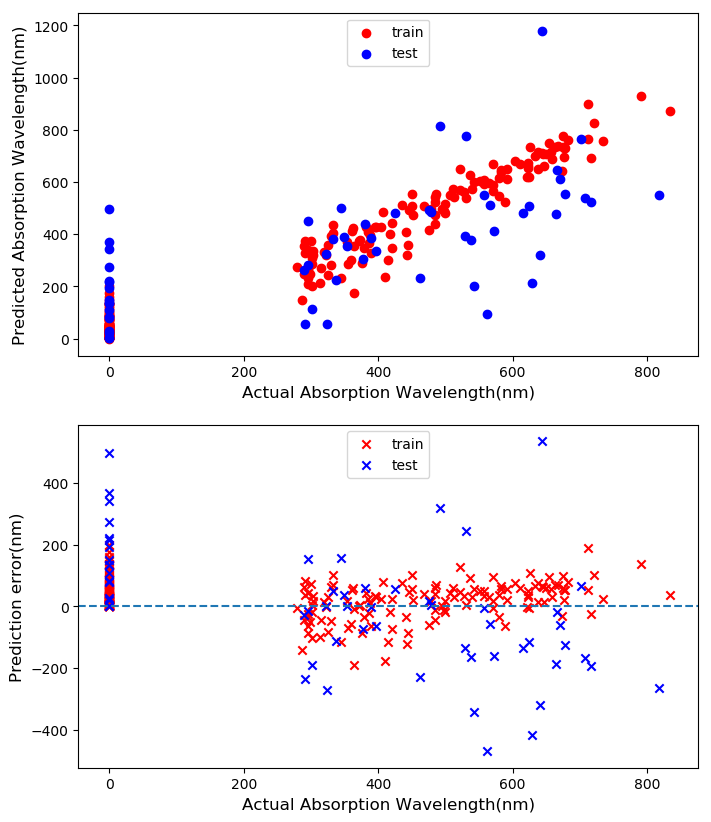

In [27]:
plot_model_error(X_train, X_test, y_train, y_test, model, save_fig_fname = None)